In [1]:
import os, sys
currentdir = os.path.dirname(os.getcwd())
sys.path.append(currentdir)

import yaml
import numpy as np
import matplotlib.pyplot as plt

from utils import models_new
from utils.preprocessing import prepare_dataset_reg

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
def load_classifier(config):
    vocab         = config['Vocab_size']
    filters       = config['filters']
    kernels       = config['kernels']
    dilations     = config['dilations']
    strides       = config['strides']
    use_attention = config['use_attention']
    file          = config['file']
    
    reg_model = models_new.Classifier(filters, kernels, strides, dilations, vocab)
    reg_model.load_weights(file)
    return reg_model

def load_data(config):
    """ Function to load all the data """
    # Parameters
    file_thermo = config['file_thermo']
    file_meso   = config['file_meso']
    seq_length  = config['seq_length']
    max_samples = config['max_samples']
    
    thermo_train, thermo_val, n_thermo_train, n_thermo_val = prepare_dataset(file_thermo, 
                                                                             seq_length = seq_length,
                                                                             max_samples = max_samples)
    
    meso_train, meso_val, n_meso_train, n_meso_val = prepare_dataset(file_meso,
                                                                     seq_length = seq_length,
                                                                     max_samples = max_samples)

    data = {'thermo_train': thermo_train,
            'meso_train': meso_train,
            'thermo_val': thermo_val,
            'meso_val': meso_val,
            'n_thermo_train': n_thermo_train,
            'n_meso_train': n_meso_train,
            'n_thermo_val': n_thermo_val,
            'n_meso_val': n_meso_val}
    
    return data

In [4]:
# Load configuration file
with open("config.yaml", 'r') as file_descriptor:
    config = yaml.load(file_descriptor, Loader=yaml.FullLoader)
model = load_classifier(config['Classifier'])

dir_ = '/mnt/Archive/Data_Sets/OGT/ogt_classes'

names_class = ['ogt_4_15.fasta', 'ogt_26_37.fasta', 'ogt_48_59.fasta', 'ogt_70_81.fasta']
names_reg = ['ogt_4_15.fasta', 'ogt_15_26.fasta', 'ogt_26_37.fasta', 'ogt_37_48.fasta', 'ogt_48_59.fasta', 'ogt_59_70.fasta', 'ogt_70_81.fasta']


data_train, data_val = prepare_dataset_reg(dir_, names_reg,
                               seq_length = 512,
                               t_v_split = 0.1,
                               max_samples = 3500)

ogt_4_15.fasta 3501
ogt_15_26.fasta 3501
ogt_26_37.fasta 3501
ogt_37_48.fasta 3501
ogt_48_59.fasta 3501
ogt_59_70.fasta 3501
ogt_70_81.fasta 3501


In [67]:
batch_size = 1

x_val = data_val.batch(batch_size, drop_remainder=False)
s = 0
count = 0
temp = np.zeros([2448,])
pred_temp = np.zeros([2448,])
for i, x in enumerate(x_val):    
    out = model(x[0], training=True)
    temp[i*batch_size:i*batch_size+batch_size] = x[1].numpy()
    pred_temp[i*batch_size:i*batch_size+batch_size] = out[0][0].numpy()
    for j in zip(out, x[1].numpy()):
        s += j[0][0].numpy() - j[1]
        count += 1

print(count, s)

2451 3728.8703174591064


In [68]:
temp = temp + 41.9
pred_temp = pred_temp + 41.9

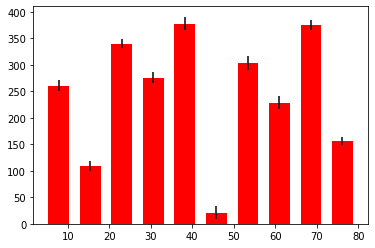

In [72]:

y,binEdges = np.histogram(temp,bins=10)

l = np.zeros_like(y)
for i in range(binEdges.size-1):
    tmp_1 = temp > binEdges[i]
    tmp_2 = temp < binEdges[i+1]
    tmp = np.logical_and(tmp_1,tmp_2)

    l[i] = np.std(temp[tmp] - pred_temp[tmp])




bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
width      = 5
plt.bar(bincenters, y, width=width, color='r', yerr=l)
plt.show()

In [73]:
print(l)

[10  9  9 11 13 12 13 12 10  8]


In [71]:
print(pred_temp[:100])
print(temp[:100])

[66.52627792 52.90303841 43.61835542 20.70944252 49.63135281 33.14695778
 28.63151588 46.82748117 26.4898447  24.73755112 67.99482193 70.55284348
 26.82173195 56.69394054 31.37362423 27.21461334 29.1343359  56.27755299
 43.19748273 47.61014071 21.3084053  26.63566246 71.46311798 26.04377213
 45.77184191 31.11428871 60.3805336  28.93396893 27.2632431  68.30638542
 62.33928719 28.26828136 44.63343396 35.97951927 65.58664742 62.70008507
 64.79005089 58.11945572 63.34420242 34.83598032 73.41376915 22.86250343
 27.59158936 25.66887512 54.94051399 59.02554359 34.02282228 66.73535576
 28.34789505 42.70577534 21.62170258 57.40275612 32.47396221 15.32780113
 32.15272465 34.75800362 21.22830048 20.45355263 66.49085083 58.87764587
 37.68493357 54.98618069 18.50114861 16.92570152 34.71021786 31.60971775
 46.4017519  47.06943598 65.18207397 29.82969894 19.96582642 24.79905357
 38.43199363 66.54083672 46.83138552 24.13640251 71.80404129 39.73338022
 39.38670411 34.49565115 32.38740482 29.41414204 64